In [2]:
from scipy.stats import multivariate_normal as mnorm
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import math
from tqdm import tqdm
from scipy.optimize import minimize, basinhopping
import optuna

# Simple Regression Problem

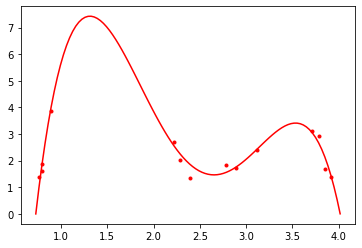

In [2]:
rng = np.random.default_rng(seed=1354)
N = 100
exp_er = 0.2 #10
# def truef(x):
#     return x**2+1
def truef(x):
    a,b,c,d,e,f = -1.6,1.8,-6,0,2.4,2.5
    return -(e*(x-f)**4+d*(x-f)**3+c*(x-f)**2+b*(x-f)+a)
x = np.linspace(0.729,4.015,N) #(1,10,10)
y = truef(x)
xd_indicies = [int(1*(N/100)),int(2*(N/100)),int(2.5*(N/100)),int(5*(N/100)),int(45*(N/100)),int(47*(N/100)),int(50*(N/100)),int(62*(N/100)),int(65*(N/100)),int(72*(N/100)),int(90*(N/100)),int(92*(N/100)),int(94*(N/100)),int(96*(N/100))]
# xd_indicies = np.linspace(0,N-1,20).astype(int)
# xd_indicies = range(N)
xd = x[xd_indicies]
M = len(xd)
yd = rng.normal(loc=truef(xd),scale=exp_er)

figSRP = plt.figure()
plt.plot(x,y,'r')
plt.plot(xd,yd,'r.')
plt.show()

prior_mean_vector = np.repeat(4,N)

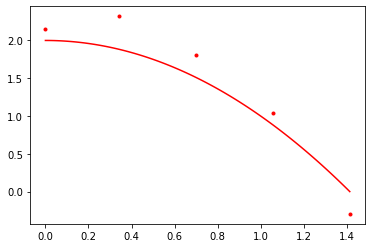

In [53]:
#Parabilic Electron Density
rng = np.random.default_rng(seed=1245)
N = 100
exp_er = 0.2 #10
def para(x):
    return -x**2+2
x = np.linspace(0,1.414,N)
y = para(x)
# xd_indicies = [int(1*(N/100)),int(2*(N/100)),int(2.5*(N/100)),int(5*(N/100)),int(45*(N/100)),int(47*(N/100)),int(50*(N/100)),int(62*(N/100)),int(65*(N/100)),int(72*(N/100)),int(90*(N/100)),int(92*(N/100)),int(94*(N/100)),int(96*(N/100))]
xd_indicies = np.linspace(0,N-1,5).astype(int)
# xd_indicies = range(N)

# y DATA
xd = x[xd_indicies]
M = len(xd)
yd = rng.normal(loc=para(xd),scale=exp_er)

#y' data
xprime = np.linspace(0,1.414,50)
xdprime = [0]
Mprime = len(xdprime)
ydprime = [0]

figSRP = plt.figure()
plt.plot(x,y,'r')
plt.plot(xd,yd,'r.')
plt.show()

prior_mean_vector = np.repeat(4,N)

In [5]:
#These are necessary to avoid 0 and infinities from inv and det of large matracies
def chol_inv(A):
    L = np.linalg.cholesky(A)
    return np.linalg.inv(L).T @ np.linalg.inv(L)
def chol_det(A):
    L = np.linalg.cholesky(A)
    return np.prod(np.diag(L))

# Gaussian Process Regression 3
See notes, uses bayes theorum and the prediction can have many x values. Also applicable to interferometry. 

      fun: 0.15334660562647162
 hess_inv: array([[3.1786181 , 1.00052272],
       [1.00052272, 0.78917999]])
      jac: array([8.58306885e-06, 5.33461571e-06])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 12
     njev: 13
   status: 0
  success: True
        x: array([2.25890119, 1.30261536])
best Marge Li 0.15334660562647162


Not good if zero, as need to be inverted.


K [[5.10263458 5.10232784 5.10140778 5.09987472]
 [5.10232784 5.10263458 5.10232784 5.10140778]
 [5.10140778 5.10232784 5.10263458 5.10232784]
 [5.09987472 5.10140778 5.10232784 5.10263458]]
The Determinent of K is: 0.0
The Determinent of cov_li is: 1.6384000000000116e-10
The Determinent of cov_post3 is: 0.0


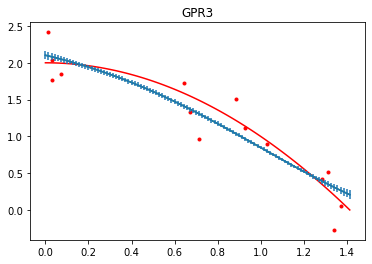

In [10]:
##Prior
mu_prior = prior_mean_vector
#exponential square kernel
def Kernel(x1,x2,params):
    x1 = x1
    x2 = x2
    #amplitude determins how far the model can go from the mean
    amp = params[0]
    #length scale determines smoothness, how correlated the function should be at a distance
    l = params[1]
    return amp**2 * np.exp(-((x1-x2)*(x1-x2))/(2*l**2))

def KRcov_li(params,trial_exp_er):
    X1, X2 = np.meshgrid(x,x)
    #covergence matrix of Prior
    K = Kernel(X1,X2,params)
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    K[np.diag_indices_from(K)] += 1e-8 
    #covergence matrix of Likelyhood
    cov_li = np.diag(np.repeat(trial_exp_er,len(xd)))
    #R is a matrix that can take a potential function vector f_N and only return M values corresponding to f(x_1)...f(x_M) 
    R = np.zeros((M,N))
    for i in range(M):
        R[i,xd_indicies[i]]=1
    return K, R, cov_li


def MargLi(params):
    K, R, cov_li = KRcov_li(params,exp_er)
    invertable = cov_li+R@K@R.T
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    invertable[np.diag_indices_from(invertable)] += 1e-8 
#     try:
#         L = np.linalg.cholesky(test_matrix)
#     except np.linalg.LinAlgError:
#         return 1.7e307
    return 0.5*np.log(chol_det(cov_li + R@K@R.T)) + 0.5*(yd.T@chol_inv(cov_li+R@K@R.T)@yd)                
    
x0=[2.6,0.094]
results = minimize(MargLi, x0=x0)
# results = basinhopping(MargLi, x0=x0, niter=100)
print(results)
best_params = results.x
# best_params = x0
print('best Marge Li', MargLi(best_params))

#little data
# best_params = (7.4,0.7)
# print('margi LI',MargLi(*best_params,exp_er))

# print('best Params',best_params)
# print('loggli',best_margli)


def PlotBest(params,trial_exp_er): 
    K, R, cov_li = KRcov_li(params,trial_exp_er)
    cov_post3 = chol_inv(R.T @ chol_inv(cov_li) @ R + chol_inv(K))
    mu_post3 = mu_prior + cov_post3 @ R.T @ chol_inv(cov_li) @ (yd - R @ mu_prior)
    error_bars3 = np.diagonal(cov_post3)

    print('\n\nNot good if zero, as need to be inverted.')
    print('\n\nK',K[:4,:4])
    print('The Determinent of K is:', np.linalg.det(K))
    print('The Determinent of cov_li is:', np.linalg.det(cov_li))
    print('The Determinent of cov_post3 is:', np.linalg.det(cov_post3))

    figGPR3 = plt.figure()
    plt.title('GPR3')
    plt.plot(x,y,'r')
    plt.plot(xd,yd,'r.')
    plt.plot(x,mu_post3,'g')
    
    plt.errorbar(x, mu_post3, yerr=error_bars3)
    plt.show()

PlotBest(best_params, exp_er)


In [ ]:
import optuna

def objective(trial):
    amp = trial.suggest_float('amp', 0, 20)
    l = trial.suggest_float('l', 0, 4)
    params = [amp,l]
    return MargLi(params)
    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

study.best_params

In [79]:
results

      fun: 4.71578696020939
 hess_inv: array([[1.60813141e-05, 1.44127841e-06],
       [1.44127841e-06, 1.29320615e-07]])
      jac: array([1.75833702e-05, 4.41074371e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 222
      nit: 17
     njev: 70
   status: 2
  success: False
        x: array([7.35781514, 0.73227267])

In [59]:
results

                        fun: 23541.30342439663
 lowest_optimization_result:       fun: 23541.30342439663
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ -2.70092773, 253.48242188])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 25
      nit: 0
     njev: 5
   status: 2
  success: False
        x: array([1010.80415426,   37.2600445 ])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 501
                       nfev: 11076
                        nit: 500
                       njev: 2962
                          x: array([1010.80415426,   37.2600445 ])

# Gaussian Processes 1

This way assumes the data and predictions come from a large multivariate distribution and then uses conditional theorums to find the posterior.



RESULTS       fun: 0.1533466055195074
 hess_inv: array([[3.22335994, 0.9906351 ],
       [0.9906351 , 0.77362918]])
      jac: array([3.96370888e-06, 4.88758087e-06])
  message: 'Optimization terminated successfully.'
     nfev: 42
      nit: 12
     njev: 14
   status: 0
  success: True
        x: array([2.25888767, 1.30261108])


MargLi 0.1533466055195074
Probably not good if 0. cov_D definetly cannot be 0 as it is inverted.


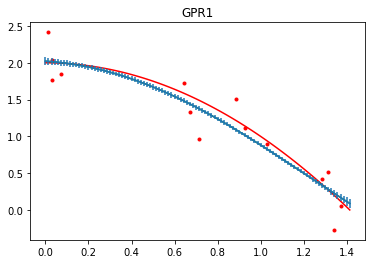

In [9]:
#KERNEL: exponential square kernel
def Kernel(x1,x2,params):
    amp = params[0]
    'How far should be between x1 and x2 for f(x1) to be uncorrelated with f(x2)'
    l = params[1]
    return amp**2 * np.exp(-((x1-x2)*(x1-x2))/(2*l**2))



X1, X2 = np.meshgrid(xd,xd)
X1st, X2st = np.meshgrid(x,x)
X1st2, X22 = np.meshgrid(x,xd)


#optimising kernel paramaters via marginal likelyhood
def MargLi(params):
    K, R, cov_li = KRcov_li(params,exp_er)
    invertable = cov_li+R@K@R.T
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    invertable[np.diag_indices_from(invertable)] += 1e-8 
    return 0.5*np.log(chol_det(cov_li + R@K@R.T)) + 0.5*(yd.T@chol_inv(cov_li+R@K@R.T)@yd)                

x0=[3.15,0.096]
results = minimize(MargLi, x0=x0)
# results = basinhopping(MargLi, x0=x0, niter=200)
print('\n\nRESULTS',results)
best_params = results.x
# best_params = x0

print('\n\nMargLi',MargLi(best_params))

K = Kernel(X1,X2,best_params)
#add a small term onto diagonal of matricies to be inverted.
#this ensures it is positive definate and cholensky matrix can be computed
K[np.diag_indices_from(K)] += 1e-8 

Kstst = Kernel(X1st, X2st,best_params)
Kst = Kernel(X22, X1st2,best_params)
##Data Dist, has prior in it
mu_D = prior_mean_vector
cov_D = K + np.diag(np.repeat(exp_er,len(xd)))


print('Probably not good if 0. cov_D definetly cannot be 0 as it is inverted.')
# print('The Determinent of K is:', chol_det(K))
# print('The Determinent of Kst is:', chol_det(Kst))
# print('The Determinent of Kstst is:', chol_det(Kstst))
# print('The Determinent of cov_D is:', chol_det(cov_D))
##Predictions dist
mu_yst = np.repeat(0,N)
cov_yst = Kstst



cov_post1 = Kstst - Kst.T @ chol_inv(cov_D) @ Kst
mu_post1 = Kst.T @ chol_inv(cov_D) @ yd
error_bars1 = np.diagonal(cov_post1)


figGPR1 = plt.figure()
plt.title('GPR1')
plt.plot(x,y,'r')
plt.plot(xd,yd,'r.')
plt.plot(x,mu_post1,'g')
plt.errorbar(x, mu_post1, yerr=error_bars1)
plt.show()

# Including Gradient Information 

In [55]:
#KERNEL: exponential square kernel
def Kernel(x1,x2,params):
    amp = params[0]
    'How far should be between x1 and x2 for f(x1) to be uncorrelated with f(x2)'
    l = params[1]
    return amp**2 * np.exp(-((x1-x2)*(x1-x2))/(2*l**2))

def KernelPrime(x1,x2,params):
    amp = params[0]
    'How far should be between x1 and x2 for f(x1) to be uncorrelated with f(x2)'
    l = params[1]
    return Kernel(x1,x2,params) * 1/l**2 * x1-x2

    
def KernelPrimePrime(x1,x2,params):
    amp = params[0]
    'How far should be between x1 and x2 for f(x1) to be uncorrelated with f(x2)'
    l = params[1]
    return KernelPrime(x1,x2,params) * (x1-x2)/l**2 - 1/l**2 * amp * Kernel(x1, x2, params)

#K box **, top left, top right, bottom right
Xprprstst1, Xprprstst2 = np.meshgrid(xprime, xprime)
Xprststj1, Xprststj2 = np.meshgrid(x, xprime)
Xstst1, Xstst2 = np.meshgrid(x,x)
Xprststi1, Xprststi2 = np.meshgrid(xprime, x)

#K box *
Xprprst1, Xprprst2 = np.meshgrid(xdprime,xprime)
Xprstj1, Xprstj2 = np.meshgrid(xd,xprime)
Xst1, Xst2 = np.meshgrid(xd,x)
Xprsti1, Xprsti2 = np.meshgrid(xdprime,x)
print(Xprstj1.shape, Xprstj2.shape)

# K box
Xprpr1, Xprpr2 = np.meshgrid(xdprime, xdprime)
Xprj1, Xprj2 = np.meshgrid(xd, xdprime)
X1, X2 = X1, X2 = np.meshgrid(xd,xd)
Xpri1, Xpri2 = np.meshgrid(xdprime, xd)


# X1, X2 = np.meshgrid(xd,xd)
# Xstst1, Xstst2 = np.meshgrid(x,x)
# Xst1, Xst2 = np.meshgrid(x,xd)

#optimising kernel paramaters via marginal likelyhood
# def MargLi(params):
#     K, R, cov_li = KRcov_li(params,exp_er)
#     invertable = cov_li+R@K@R.T
#     #add a small term onto diagonal of matricies to be inverted.
#     #this ensures it is positive definate and cholensky matrix can be computed
#     invertable[np.diag_indices_from(invertable)] += 1e-8 
#     return 0.5*np.log(chol_det(cov_li + R@K@R.T)) + 0.5*(yd.T@chol_inv(cov_li+R@K@R.T)@yd)                

x0=[3.15,0.096]
# results = minimize(MargLi, x0=x0)
# results = basinhopping(MargLi, x0=x0, niter=200)
# print('\n\nRESULTS',results)
# best_params = results.x
best_params = x0

# print('\n\nMargLi',MargLi(best_params))

#clockwise starting from top left
Kboxstst1 = KernelPrimePrime(Xprprstst1,Xprprstst2,best_params)
Kboxstst2 = KernelPrime(Xprststj1,Xprststj2,best_params)
Kboxstst3 = Kernel(Xstst1,Xstst2,best_params)
Kboxstst4 = KernelPrime(Xprststi1,Xprststi2,best_params)

Kboxst1 = KernelPrimePrime(Xprprst1,Xprprst2,best_params)
Kboxst2 = KernelPrime(Xprstj1,Xprstj2,best_params)
Kboxst3 = Kernel(Xst1,Xst2,best_params)
Kboxst4 = KernelPrime(Xprsti1,Xprsti2,best_params)

Kbox1 = KernelPrimePrime(Xprpr1,Xprpr2,best_params)
Kbox2 = KernelPrime(Xprj1,Xprj2,best_params)
Kbox3 = Kernel(X1,X2,best_params)
Kbox4 = KernelPrime(Xpri1,Xpri2,best_params)

def FourIn1(A,B,C,D):
    print('4in1')
    print(A.shape,B.shape,C.shape,D.shape)
    one = np.concatenate((A,B),axis=1)
    two = np.concatenate((D,C),axis=1)
    return np.concatenate((one,two),axis = 0)

Kboxstst = FourIn1(Kboxstst1,Kboxstst2,Kboxstst3,Kboxstst4)
Kboxst = FourIn1(Kboxst1,Kboxst2,Kboxst3,Kboxst4)
Kbox = FourIn1(Kbox1,Kbox2,Kbox3,Kbox4)

#add a small term onto diagonal of matricies to be inverted.
#this ensures it is positive definate and cholensky matrix can be computed
Kbox[np.diag_indices_from(Kbox)] += 1e-8 

##Data Dist, has prior in it
mu_D = np.array([0 for i in range(M+Mprime)])#prior_mean_vector 
exp_er_prime = 0.0001
cov_D = Kbox + np.diag(np.concatenate((np.repeat(exp_er,M), np.repeat(exp_er_prime,Mprime))))
cov_D[np.diag_indices_from(cov_D)] += 1e-8 

print('Probably not good if 0. cov_D definetly cannot be 0 as it is inverted.')
# print('The Determinent of K is:', chol_det(K))
# print('The Determinent of Kst is:', chol_det(Kst))
# print('The Determinent of Kstst is:', chol_det(Kstst))
# print('The Determinent of cov_D is:', chol_det(cov_D))
##Predictions dist
mu_yst = np.repeat(0,N)
cov_yst = Kstst



cov_post = Kboxstst - Kboxst.T @ chol_inv(cov_D) @ Kboxst
mu_post = Kboxst.T @ chol_inv(cov_D) @ np.contatenate((ydprime,yd))

error_bars = np.diagonal(cov_post)

mu_post_yst = mu_post[Mprime:]
error_bars_yst = np.diagonal(cov_post)[Mprime:]


figGPR1 = plt.figure()
plt.title('GPR1')
plt.plot(x,y,'r')
plt.plot(xd,yd,'r.')
plt.plot(x,mu_post_yst,'g')
plt.errorbar(x, mu_post_yst, yerr=error_bars_yst)
plt.show()

(50, 5) (50, 5)
4in1
(50, 50) (50, 100) (100, 100) (100, 50)
4in1
(50, 1) (50, 5) (100, 5) (100, 1)
4in1
(1, 1) (1, 5) (5, 5) (5, 1)
Probably not good if 0. cov_D definetly cannot be 0 as it is inverted.


LinAlgError: Matrix is not positive definite

In [30]:
Xprprstst1.shape
# Xprprstst2.shape

(50, 50)

In [33]:
def FourIn1(A,B,C,D):
    one = np.concatenate((A,B),axis=1)
    two = np.concatenate((D,C),axis=1)
    return np.concatenate((one,two),axis = 0)
A = np.array([[2,4],[6,8]])
B = np.array([[2,4,5],[6,8,5]])
C = np.array([[2,4,5],[6,8,5],[9,10,11]])
D = B.T

FourIn1(A,B,C,D)

array([[ 2,  4,  2,  4,  5],
       [ 6,  8,  6,  8,  5],
       [ 2,  6,  2,  4,  5],
       [ 4,  8,  6,  8,  5],
       [ 5,  5,  9, 10, 11]])

In [ ]:
import optuna

def objective(trial):
    amp = trial.suggest_float('amp', 0, 22)
    l = trial.suggest_float('l', 0, 4)
    params = [amp,l]
    return MargLi(params)
    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

study.best_params

## Before Kernel Optimisation

The performance is highly unstable. The errors vary from wildly large to extreamly tiny. The mean vector can look like gaussian noise or closely matching the profile. Also if the space between data points to too small the kernel covariance matric seems to have a determinent of 0 and thus no inverse. Some kernel parameters also cause this to hapen. It can happen in the other matracies aswell. This can cause errors in the code if the matrix is to be inveresed. It also causes the error bars to swing from almost infinity to almost 0. 

## After Kernel Optimisation

GP1 works extreamly well after kernel optimisation. Knowing exactly how the kernel parameters influence the graph can help dramatically for selecting a prior with optuna, or initial guesses for scipy.optimise(). The amp, sets how easy it is for the posterior mean to get far from the prior mean. The higher this is the weaker the prior is. The length scale l, sets how correlated two points are. For two points with one specific x distance apart, they are said to be more correlated is l is large and less correlated if l is small. We use how correlated they are in x as exactly how correlated they are in y.  

# Gaussian Process Regression 2
See notes, uses bayes theorum but must have the same x position for data and predictions. 

# Ignore this one for now

(14,)


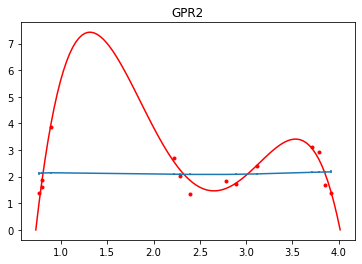

In [90]:
#exponential square kernel
def kernel(x1,x2):
    a = 10
    b = 10
    return a * np.exp(-((x1-x2)*(x1-x2))/b)
X1, X2 = np.meshgrid(xd,xd)
prior_cov = kernel(X1,X2) #np.diag(np.repeat(exp_er,len(x)))#
likelyhood_cov = np.diag(np.repeat(exp_er,len(xd)))
#Now we make the gaussian process distribution for the likelyhood
likelyhood = mnorm(mean=yd, cov=likelyhood_cov)
prior = mnorm(mean=np.repeat(0,len(xd)),cov=prior_cov, allow_singular=True)

#posterior_mean = inv(inv(prior_cov)+inv(likelyhood_cov)) @ (inv(prior_cov)@likelyhood.mean+inv(likelyhood_cov)@prior.mean)
posterior_mean = prior_cov @ inv(prior_cov + likelyhood_cov) @ likelyhood.mean  +  likelyhood_cov @ inv(prior_cov + likelyhood_cov) @ prior.mean
posterior_cov = prior_cov @ inv(prior_cov + likelyhood_cov) @ likelyhood_cov
error_bars2 = np.diagonal(posterior_cov)

print(np.shape(posterior_mean))
figGPR2 = plt.figure()
plt.title('GPR2')
plt.plot(x,y,'r')
plt.plot(xd,yd,'r.')
# plt.plot(x,posterior_mean,'g')
plt.errorbar(xd,posterior_mean, yerr=error_bars2)
plt.show()